In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import copy
from scipy import stats

In [2]:
##Niedokładności pomiarowe

def calc_DR1(rdg, dgt):
    return 0.5/100 * rdg + 1 * dgt

def calc_DR2(rdg, dgt):
    return 0.2/100 * rdg + 5 * dgt 

def calc_DU(rdg,dgt):
    return 0.8/100 * rdg + 3 * dgt

def calc_DI(rdg,dgt):
    return 1./100 * rdg + 10 * dgt

def calc_Df(rdg):
    return 1./100 * rdg + 1

#Niepewności
def calc_u_A(X):
    m = X.mean()
    s = 0
    l = X.size
    for x in X:
        s += (x-m)**2
    return (s/l/(l-1))**(1./2)

def calc_u_B(Dx):
    return Dx / np.sqrt(3)

def calc_u(uA, uB):
    return np.sqrt(uA**2 + uB**2)

def calc_u_B_U_from_series(X):
    return calc_u_B(calc_DU(X[0],X[1]))

def calc_u_B_I_from_series(X):
    return calc_u_B(calc_DI(X[0],val['resI']))


In [3]:
val = {}

In [4]:
##Opór
val['R_1'] = 153.4 #Ohm

val['Zakres_R_1'] = 400 
val['resR_1'] = 0.1 #Ohm

val['DR_1'] = calc_DR1(val['R_1'],val['resR_1'])
val['uR_1'] = calc_u_B(val['DR_1'])


val['R_L2'] = 6.1 #Ohm

val['Zakres_R_2'] = 200 
val['resR_2'] = 0.01 #Ohm

val['DR_2'] = calc_DR2(val['R_L2'],val['resR_2'])
val['uR_L2'] = calc_u_B(val['DR_2'])

In [5]:
##Częstotliwość
val['f'] = 150 #Hz
val['resf'] = 1e-6 #Hz

val['Df'] = calc_Df(val['f'])
val['uf'] = calc_u_B(val['Df'])

In [6]:
##Natężenie
val['Zakres_I'] = 200 #mA
val['resI'] = 0.01 #mA

In [7]:
##Tabela 1
data1 = pd.read_csv("tab1.txt", delimiter=" ", index_col="lp.")
#data1.set_index('Zakres_woltomierza', append=True).swaplevel(0,1)['Usk']
data1['resU'] = data1['Zakres_U'].map({4:0.001, 40:0.01})
data1.head()

,U_sk,Zakres_U,I_sk,resU
lp.,,,,
1,1.013,4,2.40,0.001
2,2.025,4,4.99,0.001
3,3.038,4,7.53,0.001
4,4.090,40,10.05,0.010
5,5.100,40,12.58,0.010


In [8]:
##Niepewności 1

data1['uU'] = data1[['U_sk','resU']].apply(calc_u_B_U_from_series, axis = 1)
data1['uI'] = data1[['I_sk']].apply(calc_u_B_I_from_series, axis = 1)

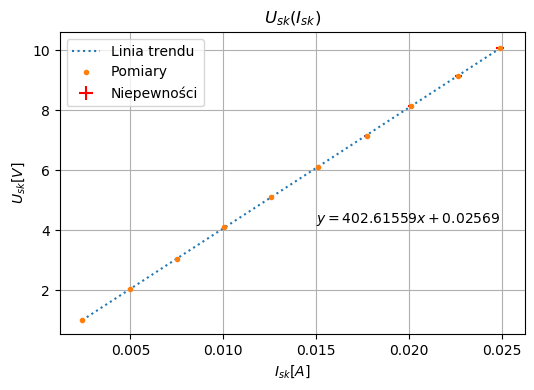

In [9]:
plt.rcParams['figure.dpi'] = 100
x = data1['I_sk'] / 1000
y = data1['U_sk']
xerr = data1['uI'] / 1000
yerr = data1['uU']
alpha, b, temp, temp, ualpha = stats.linregress(x,y)

########## Możliwe że trzeba zrobić żeby b = 0

val['Z_C'] = alpha.item()
val['uZ_C'] = ualpha.item()

plt.plot(x,alpha*x+b,':',label='Linia trendu')
#plt.plot(x,alpha*x,':',label='Linia trendu')
plt.text(0.015, 4.25, '$y={:.5f}x+{:.5f}$'.format(alpha,b))
plt.plot(x,y,'.',label="Pomiary")
plt.xlabel('$I_{sk} [A]$')
plt.ylabel('$U_{sk} [V]$')
plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr,fmt='none',color='red',label="Niepewności")
plt.grid(which='both',axis='both')
plt.legend()
plt.title("$U_{sk}(I_{sk})$")
plt.savefig("U_I_1.png",dpi=600)
plt.show()




In [10]:
# C_3 = 1 / (2 * np.pi * f * (Z_C**2 - R_1**2)**(1./2))
f, Z_C, R = sp.symbols('f Z_C R_1')
C = sp.sympify(1 / (2 * sp.pi * f * sp.sqrt(Z_C**2 - R**2)))

val['C_3'] = float(C.subs({f:val['f'], Z_C:val["Z_C"], R:val['R_1']}))

uf, uZ_C, uR = sp.symbols('u(f) u(Z_C) u(R)')
u_CC = sp.sqrt(C.diff(f)**2 * uf**2 + C.diff(Z_C)**2 * uZ_C**2 + C.diff(R)**2 * uR**2)
display(C)
display(u_CC)
val['u_CC_3'] = float(u_CC.subs({f:val['f'], uf:val['uf'], Z_C:val["Z_C"], uZ_C:val['uZ_C'], R:val['R_1'], uR:val['uR_1']}))
val['u_CC_3']

1/(2*pi*f*sqrt(-R_1**2 + Z_C**2))

sqrt(R_1**2*u(R)**2/(4*pi**2*f**2*(-R_1**2 + Z_C**2)**3) + Z_C**2*u(Z_C)**2/(4*pi**2*f**2*(-R_1**2 + Z_C**2)**3) + u(f)**2/(4*pi**2*f**4*(-R_1**2 + Z_C**2)))

2.855049532712093e-08

In [11]:
#LaTeX

print(sp.latex(C))

u_CC_1 = sp.sympify("sqrt(C.diff(f)**2 * uf**2 + C.diff(Z_C)**2 * uZ_C**2 + C.diff(R)**2 * uR**2)", evaluate = False)
display(u_CC_1)
C3 = C.subs({f:val['f'], Z_C:val["Z_C"], R:val['R_1']})
print(sp.latex(u_CC_1))
display(C3)
print(sp.latex(C.diff(f)))

\frac{1}{2 \pi f \sqrt{- R_{1}^{2} + Z_{C}^{2}}}


sqrt(0**2*uR**2 + 0**2*uZ_C**2 + 0**2*uf**2)

\sqrt{0^{2} uR^{2} + 0^{2} uZ_{C}^{2} + 0^{2} uf^{2}}


8.95463022524599e-6/pi

- \frac{1}{2 \pi f^{2} \sqrt{- R_{1}^{2} + Z_{C}^{2}}}


In [12]:
#Tabela 2
data2 = pd.read_csv("tab2.txt", delimiter=" ", index_col="lp.")
#data1.set_index('Zakres_woltomierza', append=True).swaplevel(0,1)['Usk']
data2['resU'] = data2['Zakres_U'].map({4:0.001, 40:0.01})
data2.head()

,U_sk,Zakres_U,I_sk,resU
lp.,,,,
1,1.011,4,6.19,0.001
2,2.023,4,12.53,0.001
3,3.035,4,18.88,0.001
4,4.090,40,25.19,0.010
5,5.090,40,31.57,0.010


In [13]:
#Niepewności 2
data2['uU'] = data2[['U_sk','resU']].apply(calc_u_B_U_from_series, axis = 1)
data2['uI'] = data2[['I_sk']].apply(calc_u_B_I_from_series, axis = 1)

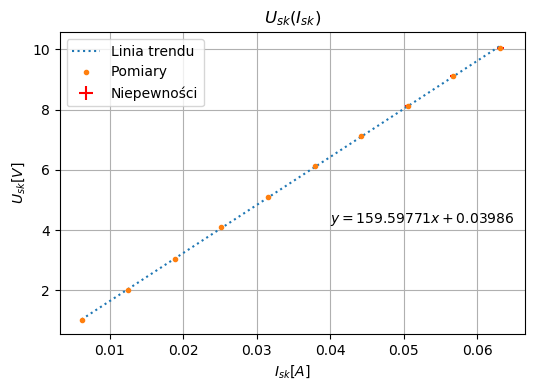

In [14]:
plt.rcParams['figure.dpi'] = 100
x = data2['I_sk'] / 1000
y = data2['U_sk']
xerr = data2['uI'] / 1000
yerr = data2['uU']
alpha, b, temp, temp, ualpha = stats.linregress(x,y)

########## Możliwe że trzeba zrobić żeby b = 0

val['Z_L'] = alpha.item()
val['uZ_L'] = ualpha.item()

plt.plot(x,alpha*x+b,':',label='Linia trendu')
#plt.plot(x,alpha*x,':',label='Linia trendu')
plt.text(0.04, 4.25, '$y={:.5f}x+{:.5f}$'.format(alpha,b))
plt.plot(x,y,'.',label="Pomiary")
plt.xlabel('$I_{sk} [A]$')
plt.ylabel('$U_{sk} [V]$')
plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr,fmt='none',color='red',label="Niepewności")
plt.grid(which='both',axis='both')
plt.legend()
plt.title("$U_{sk}(I_{sk})$")
plt.savefig("U_I_2.png",dpi=600)
plt.show()

In [15]:
Z_L, R_L = sp.symbols('Z_L R_L2')
L = sp.sqrt(Z_L**2 - (R + R_L)**2)/(2 * sp.pi * f)

val['L_2'] =float(L.subs({f:val['f'], Z_L:val["Z_L"], R:val['R_1'], R_L:val['R_L2']}))
display(L)

uf, uZ_L, uR, uR_L = sp.symbols('u(f) u(Z_L) u(R) u(R_L)')
u_CL = sp.sqrt(L.diff(f)**2 * uf**2 + L.diff(Z_L)**2 * uZ_L**2 + L.diff(R)**2 * uR**2 + L.diff(R_L)**2 * uR_L**2)
display(u_CL)

val['u_CL_2'] = float(u_CL.subs({f:val['f'], uf:val['uf'], Z_L:val["Z_L"], uZ_L:val['uZ_L'], R:val['R_1'], uR:val['uR_1'], 
                                 R_L:val['R_L2'], uR_L:val['uR_L2']}))
val['u_CL_2']

sqrt(Z_L**2 - (R_1 + R_L2)**2)/(2*pi*f)

sqrt(Z_L**2*u(Z_L)**2/(4*pi**2*f**2*(Z_L**2 - (R_1 + R_L2)**2)) + u(R)**2*(-R_1 - R_L2)**2/(4*pi**2*f**2*(Z_L**2 - (R_1 + R_L2)**2)) + u(R_L)**2*(-R_1 - R_L2)**2/(4*pi**2*f**2*(Z_L**2 - (R_1 + R_L2)**2)) + u(f)**2*(Z_L**2 - (R_1 + R_L2)**2)/(4*pi**2*f**4))

0.022631072963784207

In [16]:
print(sp.latex(L.diff(R_L)))

\frac{- R_{1} - R_{L2}}{2 \pi f \sqrt{Z_{L}^{2} - \left(R_{1} + R_{L2}\right)^{2}}}


In [17]:
##Tabela 3

data3 = pd.read_csv("tab3.txt", delimiter=" ", index_col="lp.")
#data1.set_index('Zakres_woltomierza', append=True).swaplevel(0,1)['Usk']
data3['resU'] = data3['Zakres_U'].map({4:0.001, 40:0.01})
data3.head()

,U_sk,Zakres_U,I_sk,resU
lp.,,,,
1,1.013,4,2.48,0.001
2,2.024,4,5.00,0.001
3,3.037,4,7.55,0.001
4,4.080,40,10.08,0.010
5,5.100,40,12.61,0.010


In [18]:
#Niepewności 3
data3['uU'] = data3[['U_sk','resU']].apply(calc_u_B_U_from_series, axis = 1)
data3['uI'] = data3[['I_sk']].apply(calc_u_B_I_from_series, axis = 1)

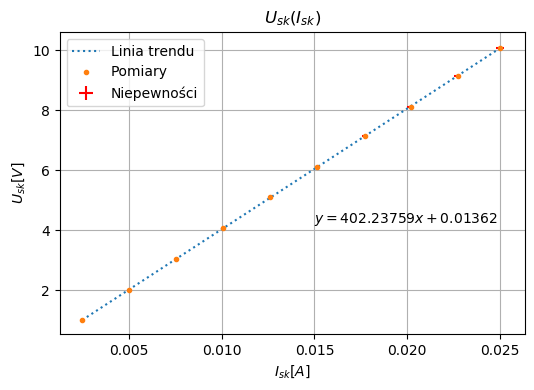

In [19]:
plt.rcParams['figure.dpi'] = 100
x = data3['I_sk'] / 1000
y = data3['U_sk']
xerr = data3['uI'] / 1000
yerr = data3['uU']
alpha, b, temp, temp, ualpha = stats.linregress(x,y)

########## Możliwe że trzeba zrobić żeby b = 0

val['Z_1'] = alpha.item()
val['uZ_1'] = ualpha.item()

plt.plot(x,alpha*x+b,':',label='Linia trendu')
#plt.plot(x,alpha*x,':',label='Linia trendu')
plt.text(0.015, 4.25, '$y={:.5f}x+{:.5f}$'.format(alpha,b))
plt.plot(x,y,'.',label="Pomiary")
plt.xlabel('$I_{sk} [A]$')
plt.ylabel('$U_{sk} [V]$')
plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr,fmt='none',color='red',label="Niepewności")
plt.grid(which='both',axis='both')
plt.legend()
plt.title("$U_{sk}(I_{sk})$")
plt.savefig("U_I_3.png",dpi=600)
plt.show()

In [20]:
L, C = sp.symbols("L_2 C_3")
Z_2 = sp.sqrt((R + R_L)**2 + (2 * sp.pi * f * L - 1/(2 * sp.pi * f * C))**2)
display(Z_2)
val['Z_2'] = float(Z_2.subs({R:val['R_1'], R_L:val['R_L2'], f:val['f'], L:val['L_2'], C:val['C_3']}))

uL_2, uC_3 = sp.symbols("u(L_2) u(C_3)")
uZ_2 = sp.sqrt(Z_2.diff(R)**2 * uR**2 + Z_2.diff(R_L)**2 * uR_L**2 + Z_2.diff(f)**2 * uf**2 +
               + Z_2.diff(L)**2 * uL_2**2 + Z_2.diff(C)**2 * uC_3**2)
display(uZ_2)

val['uZ_2'] = float(uZ_2.subs({R:val['R_1'], R_L:val['R_L2'], f:val['f'], L:val['L_2'], C:val['C_3'],
                              uR:val['uR_1'], uR_L:val['uR_L2'], uf:val['uf'], uL_2:val['u_CL_2'], uC_3:val['u_CC_3']}))
display(val['Z_1'], val['Z_2'])

#Latex
print(sp.latex(Z_2.diff(R_L)))

sqrt((R_1 + R_L2)**2 + (2*pi*L_2*f - 1/(2*pi*C_3*f))**2)

sqrt(4*pi**2*f**2*u(L_2)**2*(2*pi*L_2*f - 1/(2*pi*C_3*f))**2/((R_1 + R_L2)**2 + (2*pi*L_2*f - 1/(2*pi*C_3*f))**2) + u(R)**2*(R_1 + R_L2)**2/((R_1 + R_L2)**2 + (2*pi*L_2*f - 1/(2*pi*C_3*f))**2) + u(R_L)**2*(R_1 + R_L2)**2/((R_1 + R_L2)**2 + (2*pi*L_2*f - 1/(2*pi*C_3*f))**2) + u(f)**2*(4*pi*L_2 + 1/(pi*C_3*f**2))**2*(2*pi*L_2*f - 1/(2*pi*C_3*f))**2/(4*((R_1 + R_L2)**2 + (2*pi*L_2*f - 1/(2*pi*C_3*f))**2)) + u(C_3)**2*(2*pi*L_2*f - 1/(2*pi*C_3*f))**2/(4*pi**2*C_3**4*f**2*((R_1 + R_L2)**2 + (2*pi*L_2*f - 1/(2*pi*C_3*f))**2)))

402.237585610809

399.8524748941844

\frac{R_{1} + R_{L2}}{\sqrt{\left(R_{1} + R_{L2}\right)^{2} + \left(2 \pi L_{2} f - \frac{1}{2 \pi C_{3} f}\right)^{2}}}


In [21]:
val

{'R_1': 153.4,
 'Zakres_R_1': 400,
 'resR_1': 0.1,
 'DR_1': 0.867,
 'uR_1': 0.5005626833874056,
 'R_L2': 6.1,
 'Zakres_R_2': 200,
 'resR_2': 0.01,
 'DR_2': 0.062200000000000005,
 'uR_L2': 0.035911186743594725,
 'f': 150,
 'resf': 1e-06,
 'Df': 2.5,
 'uf': 1.4433756729740645,
 'Zakres_I': 200,
 'resI': 0.01,
 'Z_C': 402.61559065633134,
 'uZ_C': 0.9381707906471853,
 'C_3': 2.850347327815982e-06,
 'u_CC_3': 2.855049532712093e-08,
 'Z_L': 159.59771297750262,
 'uZ_L': 0.5525843876149141,
 'L_2': 0.005924706513670876,
 'u_CL_2': 0.022631072963784207,
 'Z_1': 402.237585610809,
 'uZ_1': 0.6486995670963519,
 'Z_2': 399.8524748941844,
 'uZ_2': 20.13440842241896}

In [22]:
from sympy.parsing.latex import parse_latex

a, b, c = sp.symbols("a b c")
g = sp.sqrt(a-b)/c
gda, gdb, gdc = sp.symbols("dg/da dg/db dg/dc")
ua, ub, uc = sp.symbols("u(a) u(b) u(c)")

x = r"\sqrt{\frac{\partial a}{\partial c} + b}"
x1 = parse_latex(x)
display(x1)

ug = sp.sqrt(gda**2 * ua**2 + gdb**2 * ub**2 + gdc**2 * uc**2)
display(ug)
display(ug.subs({gda:g.diff(a)}))
print(sp.latex(ug))

ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1
ANTLR runtime and generated code versions disagree: 4.8!=4.7.1


sqrt(b + Derivative(a, c))

sqrt(dg/da**2*u(a)**2 + dg/db**2*u(b)**2 + dg/dc**2*u(c)**2)

sqrt(dg/db**2*u(b)**2 + dg/dc**2*u(c)**2 + u(a)**2/(4*c**2*(a - b)))

\sqrt{dg/da^{2} u(a)^{2} + dg/db^{2} u(b)^{2} + dg/dc^{2} u(c)^{2}}


In [23]:
wynik1 = pd.DataFrame()
wynik2 = pd.DataFrame()
wynik3 = pd.DataFrame()
wynik1[[r"$U_{sk} [V]$", r"$u(U_{sk}) [V]$", r"$I_{sk} [A]$", r"$u(I_{sk}) [A]$"]] = data1[["U_sk","uU","I_sk","uI"]].copy()
wynik2[[r"$U_{sk} [V]$", r"$u(U_{sk}) [V]$", r"$I_{sk} [A]$", r"$u(I_{sk}) [A]$"]] = data2[["U_sk","uU","I_sk","uI"]].copy()
wynik3[[r"$U_{sk} [V]$", r"$u(U_{sk}) [V]$", r"$I_{sk} [A]$", r"$u(I_{sk}) [A]$"]] = data3[["U_sk","uU","I_sk","uI"]].copy()

print(wynik1.to_latex(bold_rows = True, caption = r"Układ $R_1C_3$", label = "tab:tab1", escape = False))
print(wynik2.to_latex(bold_rows = True, caption = r"Układ $R_1L_2$", label = "tab:tab2", escape = False))
print(wynik3.to_latex(bold_rows = True, caption = r"Układ $R_1L_2C_3$", label = "tab:tab3", escape = False))

\begin{table}
\centering
\caption{Układ $R_1C_3$}
\label{tab:tab1}
\begin{tabular}{lrrrr}
\toprule
{} &  $U_{sk} [V]$ &  $u(U_{sk}) [V]$ &  $I_{sk} [A]$ &  $u(I_{sk}) [A]$ \\
\textbf{lp.} &               &                  &               &                  \\
\midrule
\textbf{1  } &         1.013 &         0.006411 &          2.40 &         0.071591 \\
\textbf{2  } &         2.025 &         0.011085 &          4.99 &         0.086545 \\
\textbf{3  } &         3.038 &         0.015764 &          7.53 &         0.101210 \\
\textbf{4  } &         4.090 &         0.036211 &         10.05 &         0.115759 \\
\textbf{5  } &         5.100 &         0.040876 &         12.58 &         0.130366 \\
\textbf{6  } &         6.110 &         0.045541 &         15.12 &         0.145030 \\
\textbf{7  } &         7.130 &         0.050253 &         17.74 &         0.160157 \\
\textbf{8  } &         8.120 &         0.054825 &         20.11 &         0.173840 \\
\textbf{9  } &         9.140 &         0.0